In [1]:
import lorm
from nfft import nfft
import disc.energy_curveling_3d
from pythreejs import *
from IPython.display import display
#from ipywidgets import VBox, HBox, Checkbox, jslink
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

In [2]:
mu_N_half = 50
M = 2*mu_N_half
x = np.linspace(-0.5,0.5,M,endpoint=False)
x1,x2,x3 = np.meshgrid(x,x,x)
quat_nodes = np.array([x3.ravel()[:],x1.ravel()[:],x2.ravel()[:]]).transpose()
sample = 1.2*(np.loadtxt('data/spock.uo')-np.array([0.5,0.5,0.45]))
#mu = np.zeros([m**3],dtype=np.float)
#for s in sample:
#    mu[:] += np.exp(-30000*((quat_nodes[:,0]-s[1])**2+(quat_nodes[:,1]-s[2])**2+(quat_nodes[:,2]+s[0])**2))
#plt.imshow(mu.reshape([m,m,m])[:,:,10],vmin=0)#,vmax=1)

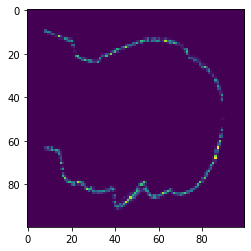

In [5]:
%matplotlib inline
mu=np.loadtxt('spock_voxel.txt')
M=int(mu.shape[0]**(1./3))+1
plt.imshow(mu.reshape([M,M,M])[:,:,50],vmin=0)#,vmax=1)
#np.savetxt('spock_voxel.txt',mu)

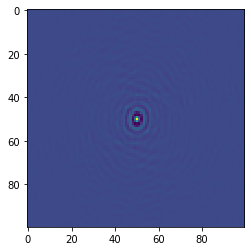

In [6]:
#mu = np.zeros([m**3],dtype=np.float)
#mu[:] = nn.exp(-10*(quat_nodes[:,0]**2+quat_nodes[:,1]**2+quat_nodes[:,2]**2))
#mu[:] = (quat_nodes[:,0]**2+quat_nodes[:,1]**2+quat_nodes[:,2]**2) < 0.45**2
#mu[:]-= (quat_nodes[:,0]**2+quat_nodes[:,1]**2+quat_nodes[:,2]**2) < 0.4**2
#plt.imshow(mu.reshape([m,m,m])[:,N_half,:],vmin=0,vmax=1)
nfft3d = nfft.NFFT3D(M**3,2*mu_N_half,2*mu_N_half,2*mu_N_half)
nfft3d.x = quat_nodes
nfft3d.precompute_x()
nfft3d.f = mu/M**3
nfft3d.adjoint()
mu_hat = np.zeros([2*mu_N_half,2*mu_N_half,2*mu_N_half],dtype=np.complex)
mu_hat[:] = nfft3d.f_hat/nfft3d.f_hat[mu_N_half,mu_N_half,mu_N_half]
plt.imshow(np.real(mu_hat[:,mu_N_half,:]))

In [7]:
e3 = lorm.manif.EuclideanSpace(3)
points = lorm.manif.ManifoldPointArray(e3)
m = 100
#points.coords = 0.3*(np.random.rand(m,3)-0.5)
points.coords = np.zeros([m,3])
t = np.linspace(0,2*np.pi,m,endpoint=False)
points.coords[:,0] = 0.3*np.sin(t)
points.coords[:,1] = 0.3*np.cos(t)
points.coords[:,2] = 0.3*np.sin(2*t)
#points.coords = 0.4*np.loadtxt('s2_4design.txt')
#points.coords = np.loadtxt('spock_lines.txt')
points_new = lorm.manif.ManifoldPointArray(e3)

In [45]:
N_half = np.int(8*np.sqrt(2)**4)
N=2*N_half
m = points.coords.shape[0]
energy = disc.energy_curveling_3d.plan(m,N,0.5,16)
#for i in range(1,N):
#    for j in range(1,N):
#        norm_squared = (i-N/2)**2+(j-N/2)**2
        #energy._lambda_hat[i,j] = 1./(np.power(1+norm_squared,3/2))
        #energy._lambda_hat[i,j] = np.exp(-0.05*norm_squared)
        #energy._lambda_hat[i,j] = 1./(np.power(1+(i-N/2)**2,3/2))/(np.power(1+(j-N/2)**2,3/2))
#        energy._lambda_hat[i,j] = 1
#print(energy._lambda_hat)
if mu_N_half >= N_half:
    energy._mu_hat[:] = mu_hat[mu_N_half-N_half:mu_N_half+N_half,mu_N_half-N_half:mu_N_half+N_half,mu_N_half-N_half:mu_N_half+N_half]
else:
    energy._mu_hat[N_half-mu_N_half:N_half+mu_N_half,N_half-mu_N_half:N_half+mu_N_half,N_half-mu_N_half:N_half+mu_N_half] = mu_hat[:]
points_new.coords = np.zeros([m,2])
m

1600

In [46]:
g1 = BufferGeometry(attributes={'position': BufferAttribute(points.coords, normalized=False) })
m1 = LineBasicMaterial(vertexColors='VertexColors', linewidth=3)
line1 = Line(g1,m1)

c = PerspectiveCamera(position=[0, 2, 2], up=[0, 2, 0],
                      children=[DirectionalLight(color='white', position=[3, 5, 1], intensity=0.5)])

scene = Scene(children=[line1, c, AmbientLight(color='#777777')])

renderer = Renderer(camera=c,
                    scene=scene, 
                    controls=[OrbitControls(controlling=c)])
renderer.width =400
renderer.height =400
display(renderer)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.5, position=(3.0, 5.0,…

<IPython.core.display.Javascript object>


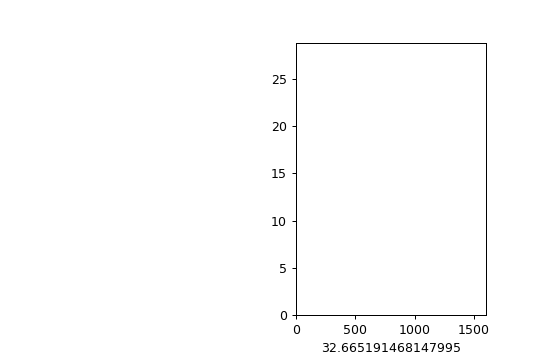

In [47]:
%matplotlib notebook
fig = plt.figure()

bx = fig.add_subplot(122)
#bx.axis(np.array([900,950,0.0045,0.0015]))
bx.axis(np.array([0,m,0.000,1.8*energy._L]))
bx.set_xlabel(np.sum(energy._eval_lengths(points.coords)))
distance = plt.Line2D(np.linspace(0,m,m),m*energy._eval_lengths(points.coords))
bx.add_line(distance)
def update_points(p):
    g1.attributes['position'].array = p.coords

    distance.set_ydata(m*energy._eval_lengths(p.coords))
    bx.set_xlabel(np.sum(energy._eval_lengths(p.coords)))
    fig.canvas.draw()
    return

In [48]:
#method = lorm.optim.SteepestDescentMethod(max_iter=100)
energy._L = 8*np.sqrt(2)**3
energy._alpha = 10/(energy._L)**5
method = lorm.optim.ConjugateGradientMethod(max_iter=100)
method.listener = update_points
points_new.coords = points.coords
for i in range(1):
    points_new = method.run(energy,points_new)

Initial value: f[0] = 0.0010445982959631083
f[1] = 0.0008501431824263103
f[2] = 0.0007513712960645185
f[3] = 0.0006750717359273996
f[4] = 0.0006389966299554379
f[5] = 0.0006148532347753307
f[6] = 0.0005918546785689079
f[7] = 0.0005771838631641236
f[8] = 0.0005643604893387665
f[9] = 0.0005563747946805891
f[10] = 0.0005510204678722825
f[11] = 0.0005462138167493309
f[12] = 0.0005424381933889469
f[13] = 0.0005395511844517547
f[14] = 0.0005374083899328252
f[15] = 0.0005353259056464365
f[16] = 0.0005333887539512737
f[17] = 0.0005313648500852349
f[18] = 0.0005298863777916492
f[19] = 0.0005284726762511033
f[20] = 0.0005267919043288617
f[21] = 0.0005254584439469076
f[22] = 0.0005242827772763805
f[23] = 0.0005232879995169184
f[24] = 0.0005221790677893883
f[25] = 0.0005212184065244048
f[26] = 0.0005205019586230662
f[27] = 0.0005196515802286786
f[28] = 0.0005189375974609578
f[29] = 0.0005182622299705696
f[30] = 0.0005177563402115852
f[31] = 0.0005171538456322665
f[32] = 0.0005165753097311611
f[33]

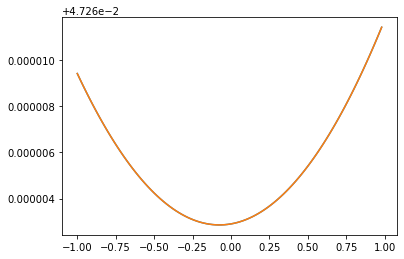

In [109]:
%matplotlib inline
v=energy.grad(points_new)
v.coords *= 10
#v.coords = 0.001*np.random.randn(m,3)
f,q, s = lorm.utils.eval_objective_function_with_quadratic_approximation(energy,v)
plt.plot(s,f,s,q)

In [44]:
tempc = points_new.coords
m2 = len(tempc)
temp = np.zeros([2*m2,3])
for i in range(m2):
    temp[2*i,:] = tempc[i,:]
for i in range(m2-1):
    temp[2*i+1,:] = (tempc[i,:]+tempc[i+1,:])/2
temp[2*m2-1,:] = (tempc[0,:]+tempc[m2-1,:])/2

m = len(temp)
points.coords = temp

In [73]:
np.sum(energy._eval_lengths(points_new.coords))

20.960702008257208

In [74]:
20.96/20

1.048

In [138]:
28/20

1.4